<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/06_transfer_learning_with_tf_scalingup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFLow: Scaling Up

Our goal is to beat the Food101 paper with 10% of the Food101 dataset


In [ ]:
# Get helper function

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-03 02:20:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-03 02:20:08 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import the series of helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir 

## 101 Food Classes

Our goal is to beat the original Food101 paper with 10% of training data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-09-03 02:20:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.130.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  63.0MB/s    in 27s     

2022-09-03 02:20:39 (56.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
unzip_data('101_food_classes_10_percent.zip')

In [ ]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [ ]:
# How many images are there
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/guacamole'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode='categorical',
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size = IMG_SIZE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning with 10% of 101 food classes
      Create Model checkpoint callback
      Create a data augmentation layer to build data augmentation into the model
      Build a headless functional Efficient B0 back bone (base)
      Compile the model
      Feature extract for 5 epochs    


In [ ]:
# Create checkpoint callback

checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                weights_only = True,
                                                monitor = ' val_accuracy',
                                                save_best_only = True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.)
], name = "data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Setup model architecture with trainable top layers

inputs = layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = 'global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output (Dense)              (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=0.001),
              metrics = ['accuracy'])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


237/237 [==============================] - ETA: 0s - loss: 3.4696 - accuracy: 0.2499

237/237 [==============================] - 95s 327ms/step - loss: 3.4696 - accuracy: 0.2499 - val_loss: 2.4211 - val_accuracy: 0.4597
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3408 - accuracy: 0.4597

237/237 [==============================] - 59s 249ms/step - loss: 2.3408 - accuracy: 0.4597 - val_loss: 1.9912 - val_accuracy: 0.5127
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9721 - accuracy: 0.5261

237/237 [==============================] - 52s 216ms/step - loss: 1.9721 - accuracy: 0.5261 - val_loss: 1.8329 - val_accuracy: 0.5326
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.7616 - accuracy: 0.5778

237/237 [==============================] - 51s 213ms/step - loss: 1.7616 - accuracy: 0.5778 - val_loss: 1.7411 - val_accuracy: 0.5514
Epoch 5/5
237/237 [==============================] - ETA: 0s - loss: 1.6143 - accuracy: 0.6037

237/237 [==============================] - 48s 202ms/step - loss: 1.6143 - accuracy: 0.6037 - val_loss: 1.7058 - val_accuracy: 0.5540


In [ ]:
# Evaluate
feature_tuning_results = model.evaluate(test_data)
feature_tuning_results

790/790 [==============================] - 58s 73ms/step - loss: 1.7326 - accuracy: 0.5477


[1.7326253652572632, 0.5477227568626404]

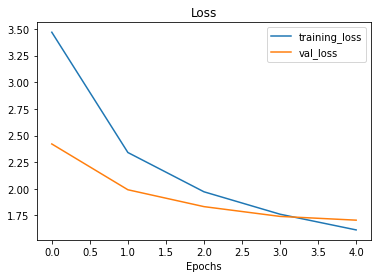

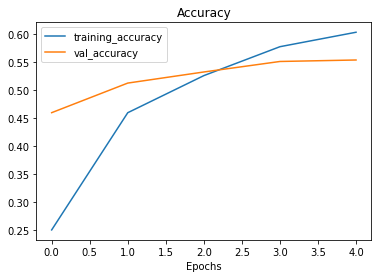

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine tuning

In [ ]:
# Unfreeze all of the layers in the base model

base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output True


In [ ]:
for layer_num, layer in enumerate(base_model.layers):
  print(layer_num, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Recompile model with lower learning rate

model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
              metrics = ['accuracy'])

# Fit

fine_tune_epochs = 10
history_all_10_percent_fine_tune = model.fit(train_data_all_10_percent,
          epochs = fine_tune_epochs,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 55s 204ms/step - loss: 1.3544 - accuracy: 0.6525 - val_loss: 1.6455 - val_accuracy: 0.5620
Epoch 6/10
237/237 [==============================] - 44s 186ms/step - loss: 1.2287 - accuracy: 0.6783 - val_loss: 1.6459 - val_accuracy: 0.5628
Epoch 7/10
237/237 [==============================] - 43s 180ms/step - loss: 1.1597 - accuracy: 0.6981 - val_loss: 1.6255 - val_accuracy: 0.5728
Epoch 8/10
237/237 [==============================] - 39s 164ms/step - loss: 1.0831 - accuracy: 0.7114 - val_loss: 1.6179 - val_accuracy: 0.5728
Epoch 9/10
237/237 [==============================] - 38s 157ms/step - loss: 1.0126 - accuracy: 0.7274 - val_loss: 1.5934 - val_accuracy: 0.5792
Epoch 10/10
237/237 [==============================] - 39s 162ms/step - loss: 0.9678 - accuracy: 0.7369 - val_loss: 1.6030 - val_accuracy: 0.5771


In [ ]:
# Evaluate on the hole test_data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 56s 71ms/step - loss: 1.6274 - accuracy: 0.5720


[1.6273703575134277, 0.5720396041870117]

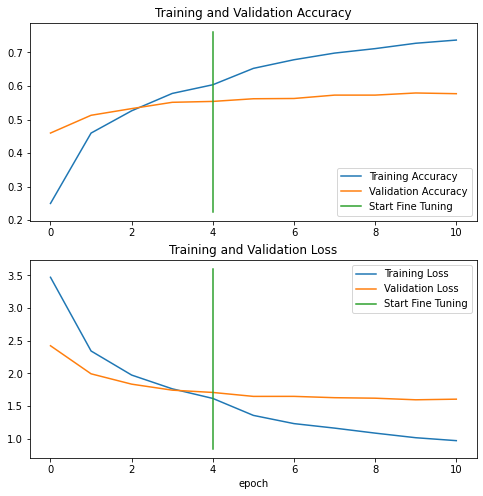

In [ ]:
# Compare history of feature extraction model with fine tune model

compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_10_percent_fine_tune)

# Saving and loading our model

To use our model in an external application we'll need to save it and export it somewhere

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/TensorflowCourse/big_dog')

In [ ]:
# Load and evalueate saved model

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TensorflowCourse/big_dog')

In [ ]:
# Evaluate loaded model and compare peroformance

loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 59s 73ms/step - loss: 1.6274 - accuracy: 0.5720


[1.6273691654205322, 0.5720396041870117]

## Evaluating the performance of all diff classes


In [26]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-09-03 03:17:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  27.2MB/s    in 1.6s    

2022-09-03 03:17:22 (27.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [28]:
# Load in saved model
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [29]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 59s 72ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with our trained model

In [30]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 64s 79ms/step


In [32]:
len(test_data), len(test_data)*32

(790, 25280)

In [33]:
len(preds_probs)

25250

In [34]:
#  Whats the shape of our predictions
preds_probs.shape

(25250, 101)